### IMPORTING THE LIBRARIES

In [372]:
import numpy as np
import pandas as pd
import sklearn 
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(69420)


### LOADING THE DATASET
Choosing only the prices column and date for index

In [373]:
train_link = "https://drive.google.com/file/d/1lKLs-uyQ85JkoXhk-Hwom5q9RRn9Fbd4/view"
train_id = train_link.split('/')[-2]

start_url ='https://drive.google.com/uc?id=' 
df = pd.read_csv(start_url + train_id, index_col='Date')
df = df[ 'Price']
df

Date
4-Jan-21     47.62
5-Jan-21     49.93
6-Jan-21     50.63
7-Jan-21     50.83
8-Jan-21     52.24
             ...  
23-Nov-22    77.94
24-Nov-22    77.95
25-Nov-22    76.28
28-Nov-22    77.24
29-Nov-22    78.20
Name: Price, Length: 505, dtype: float64

Plotting the data of the prices

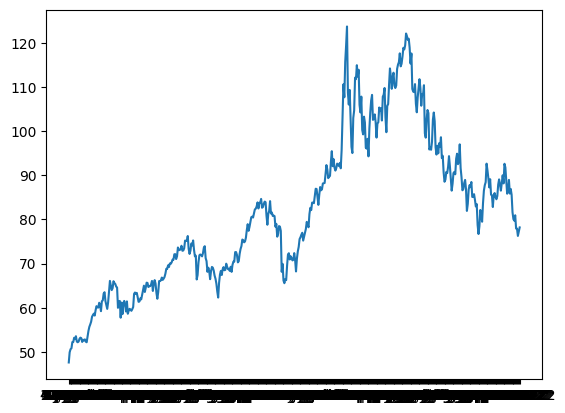

In [374]:
plt.plot(df)

* Normalising the dataset to bring the values in the range (0,1)

In [375]:
from sklearn.preprocessing import MinMaxScaler

#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
scaled_prices = normalizer.fit_transform(np.array(df).reshape(-1,1))

#### Splitting the data into training and testing data sets

In [376]:
train_size = int(len(scaled_prices)*0.7)
test_size = len(scaled_prices) - train_size


ds_train, ds_test = scaled_prices[0:train_size], scaled_prices[train_size:len(scaled_prices)]


Making the Input data (X) as the data for a 100 day prices and the output (y) is the price of the next day.

In [377]:
# creating dataset in time series for the LSTM model 
# Step determines the number of data that is used for the input feature

def create_dataset(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

#Taking 20 days price as one record for training
time_stamp = 20
X_train, y_train = create_dataset(ds_train,time_stamp)
X_test, y_test = create_dataset(ds_test,time_stamp)

Importing the LSTM model from TensorFlow.keras

In [378]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

tensorflow.random.set_seed(69420)
tensorflow.keras.utils.set_random_seed(69420)

Reshaping the data to be fed into the model to a 3D array


In [379]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

Initialising the model and Adding Layers into it

In [380]:
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 20, 50)            10400     
                                                                 
 lstm_61 (LSTM)              (None, 20, 50)            20200     
                                                                 
 lstm_62 (LSTM)              (None, 50)                20200     
                                                                 
 dense_20 (Dense)            (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


Defining the optimizer and the criterion(loss) for the Model. 

In [381]:
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=10)

Epoch 1/100
34/34 [==============================] - 4s 39ms/step - loss: 0.0341 - val_loss: 0.0054
Epoch 2/100
34/34 [==============================] - 0s 14ms/step - loss: 0.0057 - val_loss: 0.0126
Epoch 3/100
34/34 [==============================] - 0s 14ms/step - loss: 0.0058 - val_loss: 0.0242
Epoch 4/100
34/34 [==============================] - 0s 14ms/step - loss: 0.0052 - val_loss: 0.0128
Epoch 5/100
34/34 [==============================] - 0s 14ms/step - loss: 0.0048 - val_loss: 0.0139
Epoch 6/100
34/34 [==============================] - 0s 14ms/step - loss: 0.0057 - val_loss: 0.0091
Epoch 7/100
34/34 [==============================] - 0s 14ms/step - loss: 0.0040 - val_loss: 0.0043
Epoch 8/100
34/34 [==============================] - 0s 15ms/step - loss: 0.0039 - val_loss: 0.0055
Epoch 9/100
34/34 [==============================] - 0s 14ms/step - loss: 0.0038 - val_loss: 0.0041
Epoch 10/100
34/34 [==============================] - 0s 14ms/step - loss: 0.0045 - val_loss: 0.0040

Predictions on the training and testing sets

In [382]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

5/5 [==============================] - 0s 4ms/step


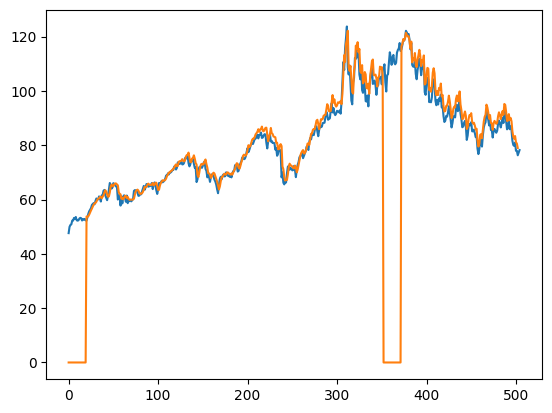

In [383]:
#Comparing the predictions with the original data
plt.plot(normalizer.inverse_transform(scaled_prices))

plt.plot(np.vstack((np.zeros((20,1)), train_predict, np.zeros((20,1)), test_predict)))
# plt.plot(test_predict)

Combining the train_predict and test_predict using the vstack function to obtain the final test set and plotting its result

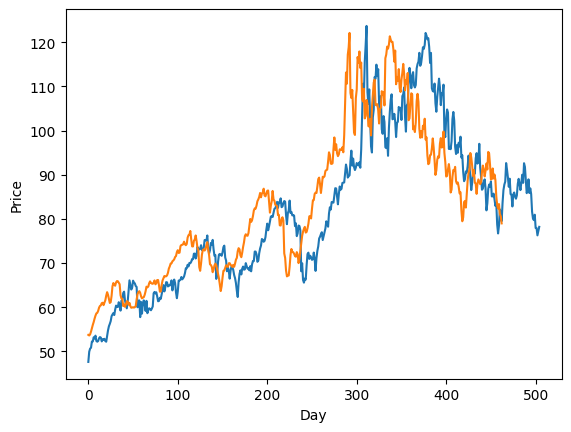

In [384]:
test = np.vstack((train_predict,test_predict))
plt.ylabel("Price")
plt.xlabel("Day")
plt.plot(normalizer.inverse_transform(scaled_prices))
plt.plot(test)

Predicting the next day price using the last 100 entries of the data

In [385]:
#Getting the last 100 days records
fut_inp = ds_test[len(ds_test) - time_stamp:]
fut_inp = fut_inp.reshape(1,-1)
print(fut_inp.shape)

#A temporary input
input = list(fut_inp)

#Creating list of the last 100 data
input = input[0].tolist()
len(input)

(1, 20)


20

* Predicting next 30 days price suing the current data
* Prediction are done in sliding window manner (algorithm) with stride 1

In [386]:
lst_output=[]
n_steps=20
i=0
while(i<30): 
    if(len(input)>20):
        fut_inp = np.array(input[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        input.extend(yhat[0].tolist())
        input = input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

##### Making the final Data frame of the predicted oil prices

In [387]:
#Entends helps us to fill the missing value with approx value
ds_new = scaled_prices.tolist()
ds_new.extend(lst_output)
next_30_days_prices = normalizer.inverse_transform(ds_new).tolist()[-30:]
prices = []
for i in next_30_days_prices:
    prices.append(i[0])

next_days = ['30-Nov-22']
for i in range(1,30):
    next_days.append(f'{i}-Dec-22')

predictions = pd.DataFrame(data={"prices": prices, "Date" :next_days})
predictions.set_index(['Date'], inplace=True)
predictions.to_csv('predictions_oil_prices.csv')


#### Plotting the combined final graph

535


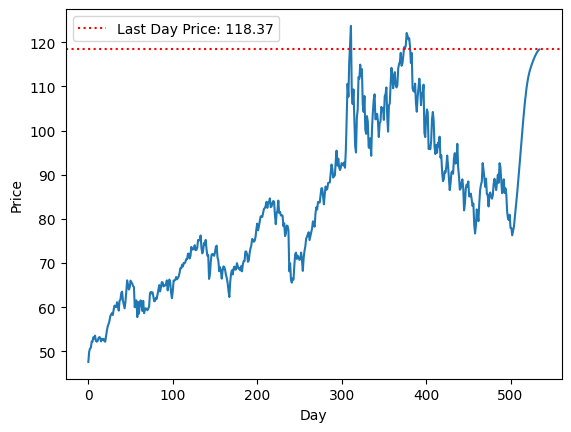

In [388]:
#Plotting final results with predicted value after 30 Days

final_graph = normalizer.inverse_transform(ds_new).tolist()
plt.plot(final_graph,)
print(len(final_graph))
plt.ylabel("Price")
plt.xlabel("Day")
# plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'Last Day Price: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()